In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
from sklearn.metrics import fbeta_score, make_scorer
def profit_scoring(y_true, y_pred):
    
    profit = rsm.profit(pd.Series(y_true), pd.Series(y_pred))
    return profit
profit_score = make_scorer(profit_scoring, greater_is_better=False)

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


### EDA, Features

In [4]:
# rsm.distr_plot(intuit75k.loc[:,'zip_bins':])

In [5]:
intuit75k['zip801'] = np.where(intuit75k['zip'] == "00801",1,0)
intuit75k['zip804'] = np.where(intuit75k['zip'] == "00804",1,0)
intuit75k['Res_zip_bin'] = np.where(intuit75k['zip_bins'] == 1,1,0)

In [6]:
def make_version_status(x, y):
    if x == 1 and y == 0:
        return "BoughtV1_CurrentV1"
    if x == 0 and y == 1:
        return "BoughtV1_CurrentV2"
    if x == 0 and y == 0:
        return "BoughtV2_CurrentV2"


intuit75k["version_status"] = intuit75k[["version1", "upgraded"]].apply(
    lambda x: make_version_status(*x), axis=1
)



In [7]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,zip801,zip804,Res_zip_bin,version_status
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,0,0,0,BoughtV2_CurrentV2
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,0,0,0,BoughtV1_CurrentV2
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,0,0,1,BoughtV2_CurrentV2
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2


In [8]:
y = np.array(intuit75k['res1_yes'])
intuit75k_modified = intuit75k.drop(columns=['zip','res1','res1_yes','sex', 'id'], axis=1)
intuit75k_modified = pd.get_dummies(intuit75k_modified)
intuit75k_modified.head()

,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,zip801,zip804,Res_zip_bin,version_status_BoughtV1_CurrentV1,version_status_BoughtV1_CurrentV2,version_status_BoughtV2_CurrentV2
0,18,0,2,109.5,5,12,0,0,0,1,0,0,0,0,0,1
1,10,0,1,69.5,4,3,0,0,0,0,0,0,0,0,0,1
2,8,0,4,93.0,14,29,0,0,1,0,0,0,0,0,1,0
3,1,0,1,22.0,17,1,0,0,0,1,0,0,1,0,0,1
4,11,0,1,24.5,2,3,0,0,0,0,0,0,0,0,0,1


In [9]:
intuit75k_cols = list(intuit75k_modified.columns)

X = np.array(intuit75k_modified)

In [10]:
cost= 1.41
margin= 60
breakeven= cost/margin

### Decision Tree  

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

SEED = 123
SEED2 = 168
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

dt = DecisionTreeClassifier(max_depth=4, random_state=SEED2, min_samples_leaf = 0.14)

MSE_CV = - cross_val_score(dt, X_train, y_train, cv= 10, scoring='neg_mean_squared_error', n_jobs = 4)

dt.fit(X_train,y_train)

y_predict_train = dt.predict(X_train)
y_predict_test = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:,1]
y_pred_proba_train = dt.predict_proba(X_train)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict_test)))
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train)))
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test)))
print('ROC AUC Score Test: {:.2f}'.format(roc_auc_score(y_test, y_pred_proba)))
print('ROC AUC Score Train: {:.2f}'.format(roc_auc_score(y_train, y_pred_proba_train)))

Accuracy: 0.95
CV MSE: 0.05
Train MSE: 0.05
Test MSE: 0.05
ROC AUC Score Test: 0.68
ROC AUC Score Train: 0.69


In [12]:
def performance_profit(X_test, y_test, model,model_name, breakeven):
    df_test = pd.DataFrame(X_test, columns=intuit75k_cols)
    df_test['res_y'] = y_test
    df_test['predict_res_proba_'+model_name] = model.predict_proba(X_test)[:,1]/2
    df_test['predicted_res_'+model_name] = np.where(df_test['predict_res_proba_'+model_name] > breakeven,1,0)
    
    confusion_matrix = pd.crosstab(df_test['res_y'], df_test['predicted_res_'+model_name], margins = True, margins_name = 'Total')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]/2)
    
    profit = rsm.profit_max(df_test, 'res_y',1 ,'predict_res_proba_'+model_name,1.41,60)
    
    print("ROC AUC is {}".format(roc_auc))
    print("Profit is {}".format(profit))
    return roc_auc,profit,confusion_matrix

In [13]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, dt, 'dt', breakeven)
cm_dt

ROC AUC is 0.681626119583636
Profit is 28336.41


predicted_res_dt,0,1,Total
res_y,,,
0,15546,5874,21420
1,455,625,1080
Total,16001,6499,22500


#### Grid Search DT

In [14]:
from sklearn.model_selection import GridSearchCV
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.14,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 168,
 'splitter': 'best'}

In [15]:
params_dt = {'max_depth': [4,5, 6, 7, 8, 9, 10],'min_samples_leaf': [0.2,0.04, 0.06, 0.08, 0.09, 0.1],'max_features': [0.2, 0.4, 0.45, 0.5, 0.6],
            'random_state': [766,168, 345]}

In [16]:
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs=6)

In [17]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=4,
                                              min_samples_leaf=0.14,
                                              random_state=168),
             n_jobs=6,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.45, 0.5, 0.6],
                         'min_samples_leaf': [0.2, 0.04, 0.06, 0.08, 0.09, 0.1],
                         'random_state': [766, 168, 345]},
             scoring='roc_auc')

In [18]:
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 6, 'max_features': 0.6, 'min_samples_leaf': 0.04, 'random_state': 345}


In [19]:
best_model = grid_dt.best_estimator_

In [20]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, best_model , 'dt', breakeven)
cm_dt

ROC AUC is 0.7397620560569906
Profit is 31321.56


predicted_res_dt,0,1,Total
res_y,,,
0,16001,5419,21420
1,415,665,1080
Total,16416,6084,22500


<br>

### Bagging Classifier

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                    stratify=y,  random_state=SEED, test_size = 0.3)

bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=4, oob_score=True)

bc.fit(X_train, y_train)

y_pred = bc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
oob_accuracy = bc.oob_score_

print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))
print('OOB accuracy: {:.3f}'.format(oob_accuracy))

Accuracy of Bagging Classifier: 0.952
OOB accuracy: 0.952


In [22]:
roc_bc, profit_bc, cm_bc = performance_profit(X_test, y_test, bc, 'bc', breakeven)
cm_bc

ROC AUC is 0.6662799348134316
Profit is 26483.7


predicted_res_bc,0,1,Total
res_y,,,
0,12653,8767,21420
1,417,663,1080
Total,13070,9430,22500


#### Grid Search BC

In [23]:
from sklearn.model_selection import GridSearchCV
bc.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 4,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 0.14,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 168,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.14, random_state=168),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 300,
 'n_jobs': 4,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
params_bc = {'base_estimator__min_samples_leaf': [0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8],'base_estimator__max_depth' : [2, 3, 4, 5, 6],
    'max_samples' : [0.05, 0.1, 0.2, 0.5], 'random_state' : [232, 168, 456]}

In [25]:
grid_bc = GridSearchCV(estimator=bc,
                       param_grid=params_bc,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs = 6)


In [ ]:
grid_bc.fit(X_train, y_train)

In [ ]:
best_hyperparams = grid_bc.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model = grid_bc.best_estimator_

In [ ]:
roc_bcbest, profit_bcbest, cm_bcbest = performance_profit(X_test, y_test, best_model , 'bcbest', breakeven)
cm_bcbest

<br>

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE


X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

rf = RandomForestClassifier(n_estimators=400,min_samples_leaf=0.12,random_state=SEED)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

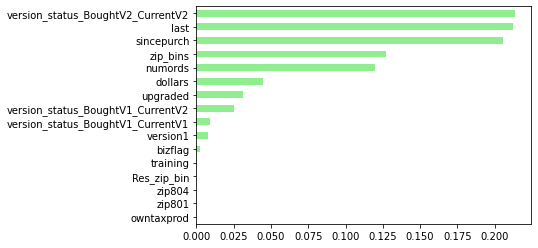

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = pd.Series(rf.feature_importances_, index = intuit75k_cols)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen'); plt.show()

In [22]:
roc_rf, profit_rf, cm_rf = performance_profit(X_test, y_test, rf, 'rf', breakeven)
cm_rf

ROC AUC is 0.687826862226372
Profit is 31288.08


predicted_res_rf,0,1,Total
res_y,,,
0,10700,10720,21420
1,288,792,1080
Total,10988,11512,22500


### Grid Search RF

In [ ]:
from sklearn.model_selection import GridSearchCV
rf.get_params()

In [ ]:
params_rf = {'criterion': ['gini', 'entropy'],
     'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
            'class_weight': ['balanced', 'balanced_subsample']}

In [ ]:
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs = 6)

In [ ]:
grid_rf.fit(X_train, y_train)

In [ ]:
best_hyperparams = grid_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model_rf = grid_rf.best_estimator_

In [ ]:
roc_rfbest, profit_rfbest, cm_rfbest = performance_profit(X_test, y_test, best_model_rf , 'rfbest', breakeven)
cm_rfbest

<br>

### ADABoost Classifier

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
adb_clf.fit(X_train, y_train)

y_pred_proba = adb_clf.predict_proba(X_test)[:,1]

adb_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)

print('ROC AUC score: {:.2f}'.format(adb_clf_roc_auc_score))

ROC AUC score: 0.72


In [25]:
roc_adb, profit_adb, cm_adb= performance_profit(X_test, y_test, adb_clf, 'adb', breakeven)
cm_adb

ROC AUC is 0.7152644421966318
Profit is 33075.0


predicted_res_adb,1,Total
res_y,,
0,21420,21420
1,1080,1080
Total,22500,22500


<br>

### Stochastic Gradient Boosting (SGB)

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

sgbt = GradientBoostingClassifier(max_depth=1,
                                 subsample = 0.8,
                                 max_features = 0.2,
                                 n_estimators = 300,
                                 random_state = SEED)

sgbt.fit(X_train, y_train)
y_pred = sgbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 0.22


In [31]:
roc_sgbt, profit_sgbt, cm_sgbt= performance_profit(X_test, y_test, sgbt, 'sgbt', breakeven)
cm_sgbt

ROC AUC is 0.753449960231006
Profit is 33031.47


predicted_res_sgbt,0,1,Total
res_y,,,
0,15884,5536,21420
1,383,697,1080
Total,16267,6233,22500


<br>